#### Inputs

In [25]:
import pandas as pd
import numpy as np
import os
import typing
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from tensorflow.keras.regularizers import l2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError, MeanSquaredLogarithmicError

from extraction.extract import *
from extraction.extractionvalues import *
from extraction.extractadjacency import getAdjacencyMatrix, distance_weight_adjacency

from sklearn.metrics import mean_absolute_error, mean_squared_error
%load_ext tensorboard
# %tensorboard --logdir logs/fit

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


##### Data parameters

In [57]:
airports = [
    "EGLL",
    "LFPG",
    "EHAM",
    "EDDF",
    "LEMD",
    "LEBL",
    # "LTFM",
    "UUEE",
    "EDDM",
    "EGKK",
]

n_nodes = n_airports = len(airports)
start = datetime(2018, 3, 1)
end = datetime(2019, 1, 1)
timeslotLength = 60

# Run settings
batch_size = 64
epochs = 1200
patience = 100
input_sequence_length = 4
forecast_horizon = 10
multi_horizon = True



##### Load Data

In [58]:
dataDict = generateNNdataMultiple(
    airports, timeslotLength, GNNFormat=True, start=start, end=end, disableWeather=True
)
times = list(dataDict.values())[0]["T"]


100%|██████████| 9/9 [00:00<00:00, 23.02it/s]


##### Process Data

In [59]:
columnsToDrop = [
    "weekend",
    "winter",
    "spring",
    "summer",
    "autumn",
    "night",
    "morning",
    "afternoon",
    "planes",
]
# print(dataDict["EGLL"]["X"].shape)
Xlist = []
Ylist = []
for airport in airports:
    # T x F
    X = dataDict[airport]["X"].drop(columnsToDrop, axis=1).to_numpy()
    Xlist.append(X)

    Y = dataDict[airport]["Y"].iloc[:, 0].to_numpy()
    Ylist.append(Y)


Xlist = np.stack(Xlist)
Ylist = np.stack(Ylist)
# N x T x F
Xarray = np.swapaxes(Xlist, 0, 1)
Yarray = np.swapaxes(Ylist, 0, 1)

# Reshape to a flat array that goes arrival then departure delay
# Yarray = np.reshape(Yarray, newshape=[len(times), len(airports)*2], order="F")

# print(Yarray.shape)
# T x N x F

# Normalise over the features
Xmean, Xstd = X.mean(axis=0), X.std(axis=0)
X = (X - Xmean) / Xstd
print("X Mean Shape", Xmean.shape)
Ymean, Ystd = Y.mean(axis=0), Y.std(axis=0)
Y = (Y - Ymean) / Ystd
print("Y Mean Shape", Ymean.shape)

print("T x N x F: ", "Xarray =", Xarray.shape, "|", "Yarray =", Yarray.shape)


X Mean Shape (8,)
Y Mean Shape ()
T x N x F:  Xarray = (2928, 9, 8) | Yarray = (2928, 9)


In [60]:
train_split, val_split = 0.6, 0.25

fullLength = len(times)
train_idx = int(train_split * fullLength)
val_idx = int((val_split + train_split) * fullLength)
print(train_idx, val_idx)

Xtrain, Xval, Xtest = Xarray[0:train_idx], Xarray[train_idx:val_idx], Xarray[val_idx::]
Ytrain, Yval, Ytest = Yarray[0:train_idx], Yarray[train_idx:val_idx], Yarray[val_idx::]


1756 2488


##### Create tensorflow dataset

In [61]:
def create_tf_dataset(
    data_array: np.ndarray,
    target_array,
    input_sequence_length: int,
    forecast_horizon: int,
    batch_size: int = 128,
    shuffle=True,
    multi_horizon=False,
):
    """Creates tensorflow dataset from numpy array.

    This function creates a dataset where each element is a tuple `(inputs, targets)`.
    `inputs` is a Tensor
    of shape `(batch_size, input_sequence_length, num_routes, 1)` containing
    the `input_sequence_length` past values of the timeseries for each node.
    `targets` is a Tensor of shape `(batch_size, forecast_horizon, num_routes)`
    containing the `forecast_horizon`
    future values of the timeseries for each node.

    Args:
        data_array: np.ndarray with shape `(num_time_steps, num_routes)`
        input_sequence_length: Length of the input sequence (in number of timesteps).
        forecast_horizon: If `multi_horizon=True`, the target will be the values of the timeseries for 1 to
            `forecast_horizon` timesteps ahead. If `multi_horizon=False`, the target will be the value of the
            timeseries `forecast_horizon` steps ahead (only one value).
        batch_size: Number of timeseries samples in each batch.
        shuffle: Whether to shuffle output samples, or instead draw them in chronological order.
        multi_horizon: See `forecast_horizon`.

    Returns:
        A tf.data.Dataset instance.
    """

    inputs = timeseries_dataset_from_array(
        data_array[:-forecast_horizon],
        None,
        sequence_length=input_sequence_length,
        shuffle=False,
        batch_size=batch_size,
    )

    dataset = inputs
    target_offset = (
        input_sequence_length
        if multi_horizon
        else input_sequence_length + forecast_horizon - 1
    )
    target_seq_length = forecast_horizon if multi_horizon else 1
    targets = timeseries_dataset_from_array(
        target_array[target_offset:],
        None,
        sequence_length=target_seq_length,
        shuffle=False,
        batch_size=batch_size,
    )

    dataset = tf.data.Dataset.zip((inputs, targets))
    if shuffle:
        dataset = dataset.shuffle(100)

    return dataset.prefetch(16).cache()


train_dataset = create_tf_dataset(
    Xtrain,
    Ytrain,
    input_sequence_length,
    forecast_horizon,
    batch_size=batch_size,
    shuffle=False,
    multi_horizon=multi_horizon,
)

val_dataset = create_tf_dataset(
    Xval,
    Yval,
    input_sequence_length,
    forecast_horizon,
    batch_size=batch_size,
    shuffle=False,
    multi_horizon=multi_horizon,
)
test_dataset = create_tf_dataset(
    Xtest,
    Ytest,
    input_sequence_length,
    forecast_horizon,
    batch_size=batch_size,
    shuffle=False,
    multi_horizon=multi_horizon,
)

print(train_dataset)

<CacheDataset shapes: ((None, None, 9, 8), (None, None, 9)), types: (tf.float64, tf.float64)>


# Adjacency Matrix

In [62]:
class GraphInfo:
    def __init__(self, edges: typing.Tuple[list, list], num_nodes: int):
        self.edges = edges
        self.num_nodes = num_nodes


distance_adj = distance_weight_adjacency(
    airports, threshold=400
)  # getAdjacencyMatrix(airports)[10]
# flight_adj = np.mean(
#     getAdjacencyMatrix(airports, start, end, timeslotLength), axis=0)
flight_adj = np.array(
    [
        [
            0.0,
            0.06728142076502733,
            0.07493169398907065,
            0.11737249544626573,
            0.08731785063752331,
            0.08691939890710383,
            0.05976775956284153,
            0.09995446265938075,
            0.00034153005464480874,
        ],
        [
            0.09221311475409882,
            0.0,
            0.07809653916211337,
            0.08891165755919873,
            0.06819216757741367,
            0.07900728597449944,
            0.09375,
            0.11372950819672131,
            0.052424863387978145,
        ],
        [
            0.09153005464480875,
            0.11270491803278689,
            0.0,
            0.07729963570127565,
            0.08965163934426229,
            0.0782103825136618,
            0.05140027322404372,
            0.07627504553734095,
            0.06841985428051031,
        ],
        [
            0.08760245901639344,
            0.08822859744990921,
            0.07821038251366169,
            0.0,
            0.07320127504553768,
            0.05794626593806932,
            0.0469603825136612,
            0.09301001821493657,
            0.0006830601092896175,
        ],
        [
            0.0875455373406198,
            0.06830601092896188,
            0.09187158469945356,
            0.07308743169398944,
            0.0,
            0.0933060109289611,
            0.05225409836065574,
            0.0617030965391622,
            0.06545992714025516,
        ],
        [
            0.08691939890710383,
            0.08014571948998225,
            0.07946265938069258,
            0.08709016393442623,
            0.09323770491803217,
            0.0,
            0.04337431693989071,
            0.08504098360655737,
            0.10040983606557388,
        ],
        [
            0.039731329690346005,
            0.06193078324225894,
            0.05140027322404372,
            0.08299180327868852,
            0.05157103825136612,
            0.08572404371584699,
            0.0,
            0.08265027322404371,
            0.0,
        ],
        [
            0.100068306010929,
            0.11321721311475409,
            0.07877959927140268,
            0.0943761384335157,
            0.09170081967213115,
            0.08487021857923498,
            0.08333333333333333,
            0.0,
            0.05362021857923497,
        ],
        [
            0.0006830601092896175,
            0.05259562841530055,
            0.07081056466302399,
            0.0,
            0.06534608378870696,
            0.10029599271402556,
            0.0,
            0.05430327868852459,
            0.0,
        ],
    ]
)
adjacency_matrix = distance_adj * 0.4 + (1 - 0.4) * flight_adj
# adjacency_matrix = distance_adj
# adjacency_matrix = np.ones((10,10))/2
# print(adjacency_matrix.shape)
# print(adjacency_matrix)
node_indices, neighbor_indices = np.where(adjacency_matrix != 0)
graph = GraphInfo(
    edges=(node_indices.tolist(), neighbor_indices.tolist()),
    num_nodes=adjacency_matrix.shape[0],
)
# print(adjacency_matrix)
# # print(adjacency_matrix.shape)
# print(np.where(adjacency_matrix != 0))
# print(np.where(adjacency_matrix != 0).shape)


In [63]:
print(flight_adj.shape)

(9, 9)


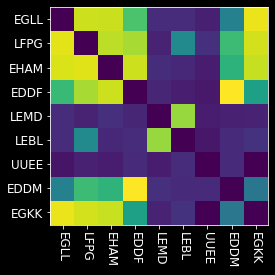

In [64]:
plt.imshow(adjacency_matrix)
plt.xticks(range(len(airports)), airports, fontsize=12, rotation=-90)
plt.yticks(range(len(airports)), airports, fontsize=12, rotation=0)
plt.show()


## Graph Convolution Layer

In [65]:
class GraphConv(layers.Layer):
    def __init__(
        self,
        in_feat,
        out_feat,
        graph_info: GraphInfo,
        aggregation_type="mean",
        combination_type="concat",
        activation: typing.Optional[str] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.graph_info = graph_info

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.weight = tf.Variable(
            initial_value=keras.initializers.glorot_uniform()(
                shape=(in_feat, out_feat), dtype="float32"
            ),
            trainable=True,
        )
        self.activation = layers.Activation(activation)

    def aggregate(self, neighbour_representations: tf.Tensor):
        aggregation_func = {
            "sum": tf.math.unsorted_segment_sum,
            "mean": tf.math.unsorted_segment_mean,
            "max": tf.math.unsorted_segment_max,
        }.get(self.aggregation_type)

        if aggregation_func:
            return aggregation_func(
                neighbour_representations,
                self.graph_info.edges[0],
                num_segments=self.graph_info.num_nodes,
            )

        raise ValueError(f"Invalid aggregation type: {self.aggregation_type}")

    def compute_nodes_representation(self, features: tf.Tensor):
        """Computes each node's representation.

        The nodes' representations are obtained by multiplying the features tensor with
        `self.weight`. Note that
        `self.weight` has shape `(in_feat, out_feat)`.

        Args:
            features: Tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        return tf.matmul(features, self.weight)

    def compute_aggregated_messages(self, features: tf.Tensor):
        neighbour_representations = tf.gather(features, self.graph_info.edges[1])
        aggregated_messages = self.aggregate(neighbour_representations)
        return tf.matmul(aggregated_messages, self.weight)

    def update(self, nodes_representation: tf.Tensor, aggregated_messages: tf.Tensor):
        if self.combination_type == "concat":
            h = tf.concat([nodes_representation, aggregated_messages], axis=-1)
        elif self.combination_type == "add":
            h = nodes_representation + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        return self.activation(h)

    def call(self, features: tf.Tensor):
        """Forward pass.

        Args:
            features: tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        nodes_representation = self.compute_nodes_representation(features)
        aggregated_messages = self.compute_aggregated_messages(features)
        return self.update(nodes_representation, aggregated_messages)


## LSTM including graph convolution layer

In [66]:
class LSTMGC(layers.Layer):
    """Layer comprising a convolution layer followed by LSTM and dense layers."""

    def __init__(
        self,
        in_feat,
        out_feat,
        lstm_units: int,
        input_seq_len: int,
        output_seq_len: int,
        graph_info: GraphInfo,
        graph_conv_params: typing.Optional[dict] = None,
        multi_thing: int = forecast_horizon,
        **kwargs,
    ):

        self.in_feat = in_feat
        self.out_feat = out_feat
        self.lstm_units = lstm_units
        self.input_seq_len = input_seq_len
        self.output_seq_len = output_seq_len
        self.graph_info = graph_info
        self.graph_conv_params = graph_conv_params
        self.multi_thing = multi_thing
        super().__init__(**kwargs)
        # graph conv layer
        if graph_conv_params is None:
            graph_conv_params = {
                "aggregation_type": "mean",
                "combination_type": "concat",
                "activation": None,
            }
        self.graph_conv = GraphConv(in_feat, out_feat, graph_info, **graph_conv_params)
        self.graph_conv2 = GraphConv(in_feat, out_feat, graph_info, **graph_conv_params)
        l2_reg = 2.5e-4  # L2 regularization rate

        self.lstm1 = layers.LSTM(
            lstm_units,
            return_sequences=True,
            activation="tanh",
            dropout=0.2,
            kernel_regularizer=l2(l2_reg),
            activity_regularizer=l2(l2_reg),
            bias_regularizer=l2(l2_reg),
        )
        self.lstm2 = layers.LSTM(
            lstm_units,
            activation="tanh",
            dropout=0.2,
            kernel_regularizer=l2(l2_reg),
            activity_regularizer=l2(l2_reg),
            bias_regularizer=l2(l2_reg),
        )
        # self.dense = layers.Dense(output_seq_len)
        self.denseThick = layers.Dense(128)
        self.denseThick2 = layers.Dense(64)
        self.denseThick3 = layers.Dense(16)
        self.dense = layers.Dense(multi_thing)

        self.input_seq_len, self.output_seq_len = input_seq_len, output_seq_len

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "in_feat": self.in_feat,
                "out_feat": self.out_feat,
                "lstm_units": self.lstm_units,
                "input_seq_len": self.input_seq_len,
                "output_seq_len": self.output_seq_len,
                "graph_info": self.graph_info,
                "graph_conv_params": self.graph_conv_params,
            }
        )
        return config

    def call(self, inputs):
        """Forward pass.

        Args:
            inputs: tf.Tensor of shape `(batch_size, input_seq_len, num_nodes, in_feat)`

        Returns:
            A tensor of shape `(batch_size, output_seq_len, num_nodes)`.
        """

        # convert shape to  (num_nodes, batch_size, input_seq_len, in_feat)
        inputs = tf.transpose(inputs, [2, 0, 1, 3])
        gcn_out = self.graph_conv(inputs)

        # print(f"The GCN output shape  = {gcn_out}")
        shape = tf.shape(gcn_out)
        num_nodes, batch_size, input_seq_len, out_feat = (
            shape[0],
            shape[1],
            shape[2],
            shape[3],
        )
        # LSTM takes only 3D tensors as input
        gcn_out = tf.reshape(gcn_out, (batch_size * num_nodes, input_seq_len, out_feat))
        # print(f"The input shape for the LSTM is {gcn_out}")
        lstmLayer1 = self.lstm1(
            gcn_out
        )  # lstm_out has shape: (batch_size * num_nodes, lstm_units)
        lstmLayer2 = self.lstm2(
            lstmLayer1
        ) 
        dense_1 = self.denseThick(lstmLayer2)
        dense_2 = self.denseThick2(dense_1)
        dense_3 = self.denseThick3(dense_2)

        dense_output = self.dense(dense_3)
        # dense_output has shape: (batch_size * num_nodes, multi_thing)

        output = tf.reshape(dense_output, (num_nodes, batch_size, forecast_horizon))
        final = tf.transpose(output, [1, 2, 0])
        return final
        # # returns Tensor of shape (batch_size, output_seq_len, num_nodes)


## Training the model

In [67]:
in_feat = Xarray.shape[2]
# batch_size = 64

# input_sequence_length = 12
# forecast_horizon = 3
# multi_horizon = False
out_feat = 15
lstm_units = 128
graph_conv_params = {
    "aggregation_type": "mean",
    "combination_type": "concat",
    "activation": None,
}

st_gcn = LSTMGC(
    in_feat,
    out_feat,
    lstm_units,
    input_sequence_length,
    forecast_horizon,
    graph,
    graph_conv_params,
)
inputs = layers.Input(
    (input_sequence_length, graph.num_nodes, in_feat)
)# , batch_size=batch_size)
outputs = st_gcn(inputs)

model = keras.models.Model(inputs, outputs)

learning_rate = 0.0001
# learning_rate = 0.0005
# learning_rate = 0.005
optimizer = Adam(learning_rate=learning_rate)
model.compile(
    optimizer=optimizer,
    loss=MeanSquaredError(reduction="auto", name="mean_absolute_error"),
    weighted_metrics=["acc"],
)

model.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 4, 9, 8)]         0         
                                                                 
 lstmgc_3 (LSTMGC)           (None, 10, 9)             239210    
                                                                 
Total params: 239,210
Trainable params: 239,210
Non-trainable params: 0
_________________________________________________________________


In [68]:
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[keras.callbacks.EarlyStopping(patience=patience), tensorboard_callback],
)


Epoch 1/1200
28/28 [==============================] - 7s 89ms/step - loss: 146.4924 - acc: 0.1182 - val_loss: 123.7818 - val_acc: 0.1497
Epoch 2/1200
28/28 [==============================] - 1s 23ms/step - loss: 124.8372 - acc: 0.1124 - val_loss: 100.7170 - val_acc: 0.1186
Epoch 3/1200
28/28 [==============================] - 1s 22ms/step - loss: 96.1728 - acc: 0.0978 - val_loss: 94.8923 - val_acc: 0.0855
Epoch 4/1200
28/28 [==============================] - 1s 21ms/step - loss: 88.8613 - acc: 0.1044 - val_loss: 91.4809 - val_acc: 0.1013
Epoch 5/1200
28/28 [==============================] - 1s 22ms/step - loss: 86.9171 - acc: 0.1098 - val_loss: 90.3808 - val_acc: 0.1275
Epoch 6/1200
28/28 [==============================] - 1s 21ms/step - loss: 86.1412 - acc: 0.1206 - val_loss: 89.4510 - val_acc: 0.1741
Epoch 7/1200
28/28 [==============================] - 1s 21ms/step - loss: 85.5715 - acc: 0.1368 - val_loss: 88.7537 - val_acc: 0.2136
Epoch 8/1200
28/28 [==============================]

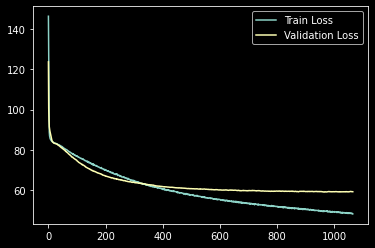

In [69]:
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()


In [70]:
windowSize = 100
hour = 3
hour = min(hour, forecast_horizon)
print(f"Hours ahead = {hour}")

Hours ahead = 3


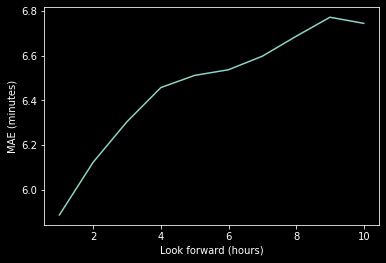

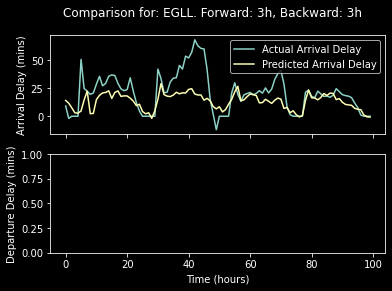

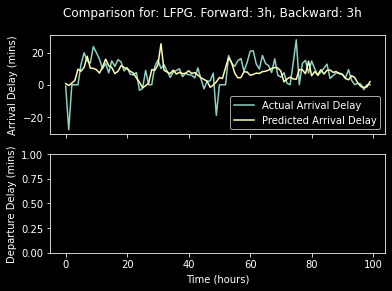

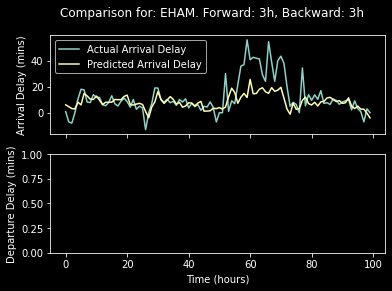

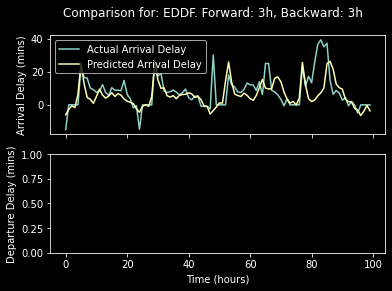

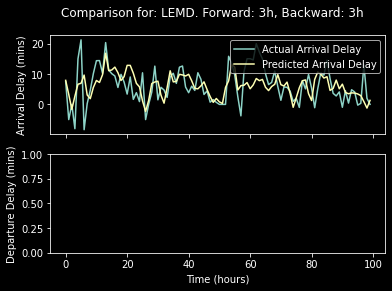

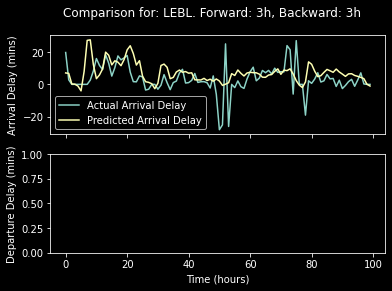

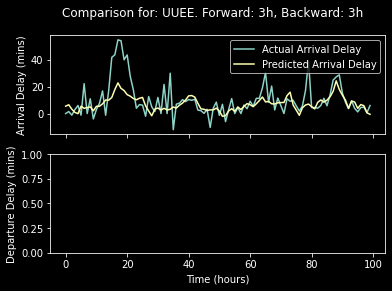

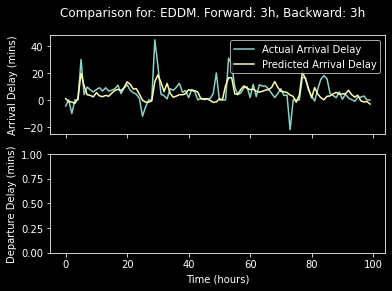

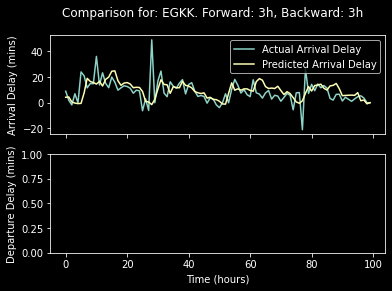

In [76]:

def getLabelArrays(hour, input_sequence_length=input_sequence_length):
    syncindex = input_sequence_length + hour - 1
    yTestPred = model.predict(test_dataset, verbose=0)
    ypredFull = yTestPred[:windowSize, hour-1, :]
    yactualFull = Ytest[syncindex:windowSize+syncindex:, :]
    mae = mean_absolute_error(ypredFull, yactualFull)

    return ypredFull, yactualFull, mae


def plotComparison(airport_index, hour):
    ypredFull, yactualFull, mae = getLabelArrays(hour)
    fig, axs = plt.subplots(2, 1, sharex=True, num=airport_index)
    axs[0].plot(yactualFull[:, 0 + airport_index], label="Actual Arrival Delay")
    # axs[1].plot(yactualFull[:, len(airports)+airport_index], label="Actual Departure Delay")
    axs[0].plot(ypredFull[:, 0 + airport_index], label="Predicted Arrival Delay")
    # axs[1].plot(ypredFull[:, len(airports)+airport_index], label="Predicted Departure Delay")
    axs[0].legend()
    # axs[1].legend()
    axs[1].set_xlabel("Time (hours)")
    axs[0].set_ylabel("Arrival Delay (mins)")
    axs[1].set_ylabel("Departure Delay (mins)")
    plt.suptitle(f"Comparison for: {airports[airport_index]}. Forward: {hour}h, Backward: {hour}h")


def plotMAEOverTime(forecast_horizon=forecast_horizon):
    hours = list(range(1, forecast_horizon+1))
    maeList = []
    for h in hours:
        _,_, mae = getLabelArrays(h)
        maeList.append(mae)
    plt.plot(hours, maeList)
    plt.xlabel("Look forward (hours)")
    plt.ylabel("MAE (minutes)")


plotMAEOverTime()
plt.show()

for airportidx in range(0, len(airports)):
    plotComparison(airportidx, hour)
# plt.show()



In [72]:
# P = generateKeplerAirports(airports, start, end, timeslotLength, [3,6,9,12], val_idx+14, yTestPred[:,0,:] , Ytest[14:])

# time_test = start + timedelta(timeslotLength*(val_idx+14))

# Q = generateKeplerFlightsMultiple(airports, time_test, end, timeslotLength, save_to_csv= True)




## Add logbook to tensorboard

In [73]:
# !tensorboard dev upload --logdir ./logs \
#   --name "Tuning model 2" \
#   --description "Trying some stuff ans last run on TOP50"\
#   --one_shot


In [74]:

# a = np.asarray(Ytest[14:])
# np.savetxt("actualy.csv", a, delimiter=",")

print(start+timedelta(minutes=timeslotLength*(val_idx+45)))

2018-06-14 13:00:00
